Can we back into the same adversary prediction abilities using only the sorted edge weights? I.e. if we just look at the top n edges in the filtration, is this good enough? Or do we actually use persistent homology effectively?

In [1]:
import os
import parse
import pickle
import copy
import math

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import cross_val_score
import sklearn
import networkx as nx
from grakel import GraphKernel
import grakel
import seaborn as sns

from pt_activation.models.simple_mnist_sigmoid import CFF

%load_ext autoreload
%autoreload 2

In [2]:
COLORS = ['#12355b', '#ff6978']
EDGE_COLOR = '#272d2d'
PLT_LABELS = ['Unaltered', 'Adversarial']

In [3]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [4]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/lbfgsm/cff_mnist_sigmoid.pt/90'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [5]:
def create_sample_graph(f):
    m = dion.homology_persistence(f)
    dgms = dion.init_diagrams(m,f)
    subgraphs = {}
    for i,c in enumerate(m):
        if len(c) == 2:
#                 print(" + ".join(["%d * %s" % (x.element, f[x.index]) for x in c]))
            if f[c[0].index][0] in subgraphs:
                subgraphs[f[c[0].index][0]].add_edge(f[c[0].index][0],f[c[1].index][0],weight=f[i].data)
            else:
                eaten = False
                for k, v in subgraphs.items():
                    if v.has_node(f[c[0].index][0]):
                        v.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                        eaten = True
                        break
                if not eaten:
                    g = nx.Graph()
                    g.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                    subgraphs[f[c[0].index][0]] = g

    return subgraphs, dgms[0]


def create_lifetimes(dgms):
    return [[pt.birth - pt.death for pt in dgm if pt.death < np.inf] for dgm in dgms]

In [6]:
def create_subgraphs(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
#                 f = model.compute_dynamic_filtration(data[s], this_hiddens)
#                 sg, dg = create_sample_graph(f)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
#                 subgraphs.append(sg)
#                 diagrams.append(dg)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams


def create_adversary_subgraphs(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
#                 f = model.compute_dynamic_filtration(data[s], this_hiddens)
#                 sg, dg = create_sample_graph(f)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
#                 subgraphs.append(sg)
#                 diagrams.append(dg)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams

In [7]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/cff_mnist_sigmoid.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [8]:
res_df, sample_graphs, dgms = create_subgraphs(model, 1, 2000)

Filtration: 0
Filtration: 1
Filtration: 2
Filtration: 3
Filtration: 4
Filtration: 5
Filtration: 6
Filtration: 7
Filtration: 8
Filtration: 9
Filtration: 10
Filtration: 11
Filtration: 12
Filtration: 13
Filtration: 14
Filtration: 15
Filtration: 16
Filtration: 17
Filtration: 18
Filtration: 19
Filtration: 20
Filtration: 21
Filtration: 22
Filtration: 23
Filtration: 24
Filtration: 25
Filtration: 26
Filtration: 27
Filtration: 28
Filtration: 29
Filtration: 30
Filtration: 31
Filtration: 32
Filtration: 33
Filtration: 34
Filtration: 35
Filtration: 36
Filtration: 37
Filtration: 38
Filtration: 39
Filtration: 40
Filtration: 41
Filtration: 42
Filtration: 43
Filtration: 44
Filtration: 45
Filtration: 46
Filtration: 47
Filtration: 48
Filtration: 49
Filtration: 50
Filtration: 51
Filtration: 52
Filtration: 53
Filtration: 54
Filtration: 55
Filtration: 56
Filtration: 57
Filtration: 58
Filtration: 59
Filtration: 60
Filtration: 61
Filtration: 62
Filtration: 63
Filtration: 64
Filtration: 65
Filtration: 66
Filtr

Filtration: 521
Filtration: 522
Filtration: 523
Filtration: 524
Filtration: 525
Filtration: 526
Filtration: 527
Filtration: 528
Filtration: 529
Filtration: 530
Filtration: 531
Filtration: 532
Filtration: 533
Filtration: 534
Filtration: 535
Filtration: 536
Filtration: 537
Filtration: 538
Filtration: 539
Filtration: 540
Filtration: 541
Filtration: 542
Filtration: 543
Filtration: 544
Filtration: 545
Filtration: 546
Filtration: 547
Filtration: 548
Filtration: 549
Filtration: 550
Filtration: 551
Filtration: 552
Filtration: 553
Filtration: 554
Filtration: 555
Filtration: 556
Filtration: 557
Filtration: 558
Filtration: 559
Filtration: 560
Filtration: 561
Filtration: 562
Filtration: 563
Filtration: 564
Filtration: 565
Filtration: 566
Filtration: 567
Filtration: 568
Filtration: 569
Filtration: 570
Filtration: 571
Filtration: 572
Filtration: 573
Filtration: 574
Filtration: 575
Filtration: 576
Filtration: 577
Filtration: 578
Filtration: 579
Filtration: 580
Filtration: 581
Filtration: 582
Filtrati

Filtration: 1034
Filtration: 1035
Filtration: 1036
Filtration: 1037
Filtration: 1038
Filtration: 1039
Filtration: 1040
Filtration: 1041
Filtration: 1042
Filtration: 1043
Filtration: 1044
Filtration: 1045
Filtration: 1046
Filtration: 1047
Filtration: 1048
Filtration: 1049
Filtration: 1050
Filtration: 1051
Filtration: 1052
Filtration: 1053
Filtration: 1054
Filtration: 1055
Filtration: 1056
Filtration: 1057
Filtration: 1058
Filtration: 1059
Filtration: 1060
Filtration: 1061
Filtration: 1062
Filtration: 1063
Filtration: 1064
Filtration: 1065
Filtration: 1066
Filtration: 1067
Filtration: 1068
Filtration: 1069
Filtration: 1070
Filtration: 1071
Filtration: 1072
Filtration: 1073
Filtration: 1074
Filtration: 1075
Filtration: 1076
Filtration: 1077
Filtration: 1078
Filtration: 1079
Filtration: 1080
Filtration: 1081
Filtration: 1082
Filtration: 1083
Filtration: 1084
Filtration: 1085
Filtration: 1086
Filtration: 1087
Filtration: 1088
Filtration: 1089
Filtration: 1090
Filtration: 1091
Filtration: 10

Filtration: 1517
Filtration: 1518
Filtration: 1519
Filtration: 1520
Filtration: 1521
Filtration: 1522
Filtration: 1523
Filtration: 1524
Filtration: 1525
Filtration: 1526
Filtration: 1527
Filtration: 1528
Filtration: 1529
Filtration: 1530
Filtration: 1531
Filtration: 1532
Filtration: 1533
Filtration: 1534
Filtration: 1535
Filtration: 1536
Filtration: 1537
Filtration: 1538
Filtration: 1539
Filtration: 1540
Filtration: 1541
Filtration: 1542
Filtration: 1543
Filtration: 1544
Filtration: 1545
Filtration: 1546
Filtration: 1547
Filtration: 1548
Filtration: 1549
Filtration: 1550
Filtration: 1551
Filtration: 1552
Filtration: 1553
Filtration: 1554
Filtration: 1555
Filtration: 1556
Filtration: 1557
Filtration: 1558
Filtration: 1559
Filtration: 1560
Filtration: 1561
Filtration: 1562
Filtration: 1563
Filtration: 1564
Filtration: 1565
Filtration: 1566
Filtration: 1567
Filtration: 1568
Filtration: 1569
Filtration: 1570
Filtration: 1571
Filtration: 1572
Filtration: 1573
Filtration: 1574
Filtration: 15

Filtration: 1999


In [9]:
adv_df, adv_sample_graphs, adv_dgms = create_adversary_subgraphs(model, 1, 2000, adversaries)

torch.Size([5671, 1, 28, 28]) torch.Size([5671])
Filtration: 0
Filtration: 1
Filtration: 2
Filtration: 3
Filtration: 4
Filtration: 5
Filtration: 6
Filtration: 7
Filtration: 8
Filtration: 9
Filtration: 10
Filtration: 11
Filtration: 12
Filtration: 13
Filtration: 14
Filtration: 15
Filtration: 16
Filtration: 17
Filtration: 18
Filtration: 19
Filtration: 20
Filtration: 21
Filtration: 22
Filtration: 23
Filtration: 24
Filtration: 25
Filtration: 26
Filtration: 27
Filtration: 28
Filtration: 29
Filtration: 30
Filtration: 31
Filtration: 32
Filtration: 33
Filtration: 34
Filtration: 35
Filtration: 36
Filtration: 37
Filtration: 38
Filtration: 39
Filtration: 40
Filtration: 41
Filtration: 42
Filtration: 43
Filtration: 44
Filtration: 45
Filtration: 46
Filtration: 47
Filtration: 48
Filtration: 49
Filtration: 50
Filtration: 51
Filtration: 52
Filtration: 53
Filtration: 54
Filtration: 55
Filtration: 56
Filtration: 57
Filtration: 58
Filtration: 59
Filtration: 60
Filtration: 61
Filtration: 62
Filtration: 63
F

Filtration: 516
Filtration: 517
Filtration: 518
Filtration: 519
Filtration: 520
Filtration: 521
Filtration: 522
Filtration: 523
Filtration: 524
Filtration: 525
Filtration: 526
Filtration: 527
Filtration: 528
Filtration: 529
Filtration: 530
Filtration: 531
Filtration: 532
Filtration: 533
Filtration: 534
Filtration: 535
Filtration: 536
Filtration: 537
Filtration: 538
Filtration: 539
Filtration: 540
Filtration: 541
Filtration: 542
Filtration: 543
Filtration: 544
Filtration: 545
Filtration: 546
Filtration: 547
Filtration: 548
Filtration: 549
Filtration: 550
Filtration: 551
Filtration: 552
Filtration: 553
Filtration: 554
Filtration: 555
Filtration: 556
Filtration: 557
Filtration: 558
Filtration: 559
Filtration: 560
Filtration: 561
Filtration: 562
Filtration: 563
Filtration: 564
Filtration: 565
Filtration: 566
Filtration: 567
Filtration: 568
Filtration: 569
Filtration: 570
Filtration: 571
Filtration: 572
Filtration: 573
Filtration: 574
Filtration: 575
Filtration: 576
Filtration: 577
Filtrati

Filtration: 1028
Filtration: 1029
Filtration: 1030
Filtration: 1031
Filtration: 1032
Filtration: 1033
Filtration: 1034
Filtration: 1035
Filtration: 1036
Filtration: 1037
Filtration: 1038
Filtration: 1039
Filtration: 1040
Filtration: 1041
Filtration: 1042
Filtration: 1043
Filtration: 1044
Filtration: 1045
Filtration: 1046
Filtration: 1047
Filtration: 1048
Filtration: 1049
Filtration: 1050
Filtration: 1051
Filtration: 1052
Filtration: 1053
Filtration: 1054
Filtration: 1055
Filtration: 1056
Filtration: 1057
Filtration: 1058
Filtration: 1059
Filtration: 1060
Filtration: 1061
Filtration: 1062
Filtration: 1063
Filtration: 1064
Filtration: 1065
Filtration: 1066
Filtration: 1067
Filtration: 1068
Filtration: 1069
Filtration: 1070
Filtration: 1071
Filtration: 1072
Filtration: 1073
Filtration: 1074
Filtration: 1075
Filtration: 1076
Filtration: 1077
Filtration: 1078
Filtration: 1079
Filtration: 1080
Filtration: 1081
Filtration: 1082
Filtration: 1083
Filtration: 1084
Filtration: 1085
Filtration: 10

Filtration: 1511
Filtration: 1512
Filtration: 1513
Filtration: 1514
Filtration: 1515
Filtration: 1516
Filtration: 1517
Filtration: 1518
Filtration: 1519
Filtration: 1520
Filtration: 1521
Filtration: 1522
Filtration: 1523
Filtration: 1524
Filtration: 1525
Filtration: 1526
Filtration: 1527
Filtration: 1528
Filtration: 1529
Filtration: 1530
Filtration: 1531
Filtration: 1532
Filtration: 1533
Filtration: 1534
Filtration: 1535
Filtration: 1536
Filtration: 1537
Filtration: 1538
Filtration: 1539
Filtration: 1540
Filtration: 1541
Filtration: 1542
Filtration: 1543
Filtration: 1544
Filtration: 1545
Filtration: 1546
Filtration: 1547
Filtration: 1548
Filtration: 1549
Filtration: 1550
Filtration: 1551
Filtration: 1552
Filtration: 1553
Filtration: 1554
Filtration: 1555
Filtration: 1556
Filtration: 1557
Filtration: 1558
Filtration: 1559
Filtration: 1560
Filtration: 1561
Filtration: 1562
Filtration: 1563
Filtration: 1564
Filtration: 1565
Filtration: 1566
Filtration: 1567
Filtration: 1568
Filtration: 15

Filtration: 1993
Filtration: 1994
Filtration: 1995
Filtration: 1996
Filtration: 1997
Filtration: 1998
Filtration: 1999


In [10]:
# with open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), 'wb') as f:
#     pickle.dump(adv_sample_graphs, f)
# with open(os.path.join(adv_directory_loc, 'samples.pkl'), 'wb') as f:
#     pickle.dump(sample_graphs, f)

sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'samples.pkl'), "rb") )
adv_sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), "rb") )

In [11]:
lifetimes = create_lifetimes(dgms)
adv_lifetimes = create_lifetimes(adv_dgms)

Text(0.5, 0, 'Mean Lifetime')

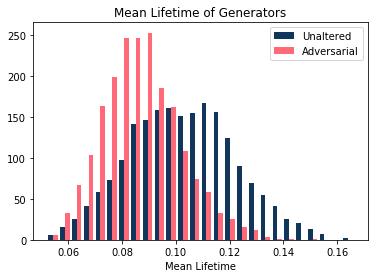

In [12]:
mls = [np.mean(l) for l in lifetimes]
adv_mls = [np.mean(l) for l in adv_lifetimes]
plt.hist([mls, adv_mls], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Mean Lifetime of Generators')
plt.xlabel('Mean Lifetime')

Text(0.5, 0, 'Median Lifetime')

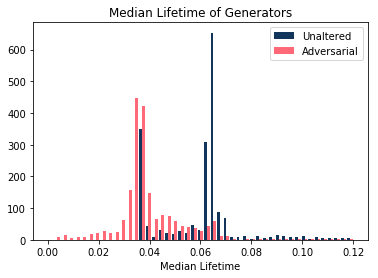

In [13]:
mls = [np.median(l) for l in lifetimes]
adv_mls = [np.median(l) for l in adv_lifetimes]
plt.hist([mls, adv_mls], bins='auto', range=[0,.12], color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Median Lifetime of Generators')
plt.xlabel('Median Lifetime')

In [15]:
# for dgm in dgms:
#     dion.plot.plot_diagram(dgm, show=True)

In [16]:
# for adv_dgm in adv_dgms:
#     dion.plot.plot_diagram(adv_dgm, show=True)

In [17]:
# thru = 3
# all_gois = []
# for i in range(len(sample_graphs)):
#     print(i)
#     ks = list(sample_graphs[i].keys())
#     a = [sample_graphs[i][k] for k in ks[:thru]]
#     all_gois.append(nx.compose_all(a))
    
# adv_all_gois = []
# for i in range(len(adv_sample_graphs)):
#     print(i)
#     ks = list(adv_sample_graphs[i].keys())
#     a = [adv_sample_graphs[i][k] for k in ks[:thru]]
#     adv_all_gois.append(nx.compose_all(a))

In [59]:
kernel = 'linear'
take = -1
edges = set()
for i in range(len(sample_graphs)):
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

In [60]:
ids = model.layerwise_ids()
ids

[range(0, 784), range(784, 2107), range(2107, 2157), range(2157, 2167)]

In [61]:
edf = pd.DataFrame(np.zeros((len(sample_graphs),len(edges))), columns=list(edges))
for i in range(len(sample_graphs)):
    print('Sample: {}/{}'.format(i,len(sample_graphs)))
    lst = list(sample_graphs[i].keys())
    for k in lst[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i][edge_name] += 10

Sample: 0/2000
Sample: 1/2000
Sample: 2/2000
Sample: 3/2000
Sample: 4/2000
Sample: 5/2000
Sample: 6/2000
Sample: 7/2000
Sample: 8/2000
Sample: 9/2000
Sample: 10/2000
Sample: 11/2000
Sample: 12/2000
Sample: 13/2000
Sample: 14/2000
Sample: 15/2000
Sample: 16/2000
Sample: 17/2000
Sample: 18/2000
Sample: 19/2000
Sample: 20/2000
Sample: 21/2000
Sample: 22/2000
Sample: 23/2000
Sample: 24/2000
Sample: 25/2000
Sample: 26/2000
Sample: 27/2000
Sample: 28/2000
Sample: 29/2000
Sample: 30/2000
Sample: 31/2000
Sample: 32/2000
Sample: 33/2000
Sample: 34/2000
Sample: 35/2000
Sample: 36/2000
Sample: 37/2000
Sample: 38/2000
Sample: 39/2000
Sample: 40/2000
Sample: 41/2000
Sample: 42/2000
Sample: 43/2000
Sample: 44/2000
Sample: 45/2000
Sample: 46/2000
Sample: 47/2000
Sample: 48/2000
Sample: 49/2000
Sample: 50/2000
Sample: 51/2000
Sample: 52/2000
Sample: 53/2000
Sample: 54/2000
Sample: 55/2000
Sample: 56/2000
Sample: 57/2000
Sample: 58/2000
Sample: 59/2000
Sample: 60/2000
Sample: 61/2000
Sample: 62/2000
Sa

Sample: 491/2000
Sample: 492/2000
Sample: 493/2000
Sample: 494/2000
Sample: 495/2000
Sample: 496/2000
Sample: 497/2000
Sample: 498/2000
Sample: 499/2000
Sample: 500/2000
Sample: 501/2000
Sample: 502/2000
Sample: 503/2000
Sample: 504/2000
Sample: 505/2000
Sample: 506/2000
Sample: 507/2000
Sample: 508/2000
Sample: 509/2000
Sample: 510/2000
Sample: 511/2000
Sample: 512/2000
Sample: 513/2000
Sample: 514/2000
Sample: 515/2000
Sample: 516/2000
Sample: 517/2000
Sample: 518/2000
Sample: 519/2000
Sample: 520/2000
Sample: 521/2000
Sample: 522/2000
Sample: 523/2000
Sample: 524/2000
Sample: 525/2000
Sample: 526/2000
Sample: 527/2000
Sample: 528/2000
Sample: 529/2000
Sample: 530/2000
Sample: 531/2000
Sample: 532/2000
Sample: 533/2000
Sample: 534/2000
Sample: 535/2000
Sample: 536/2000
Sample: 537/2000
Sample: 538/2000
Sample: 539/2000
Sample: 540/2000
Sample: 541/2000
Sample: 542/2000
Sample: 543/2000
Sample: 544/2000
Sample: 545/2000
Sample: 546/2000
Sample: 547/2000
Sample: 548/2000
Sample: 549/20

Sample: 975/2000
Sample: 976/2000
Sample: 977/2000
Sample: 978/2000
Sample: 979/2000
Sample: 980/2000
Sample: 981/2000
Sample: 982/2000
Sample: 983/2000
Sample: 984/2000
Sample: 985/2000
Sample: 986/2000
Sample: 987/2000
Sample: 988/2000
Sample: 989/2000
Sample: 990/2000
Sample: 991/2000
Sample: 992/2000
Sample: 993/2000
Sample: 994/2000
Sample: 995/2000
Sample: 996/2000
Sample: 997/2000
Sample: 998/2000
Sample: 999/2000
Sample: 1000/2000
Sample: 1001/2000
Sample: 1002/2000
Sample: 1003/2000
Sample: 1004/2000
Sample: 1005/2000
Sample: 1006/2000
Sample: 1007/2000
Sample: 1008/2000
Sample: 1009/2000
Sample: 1010/2000
Sample: 1011/2000
Sample: 1012/2000
Sample: 1013/2000
Sample: 1014/2000
Sample: 1015/2000
Sample: 1016/2000
Sample: 1017/2000
Sample: 1018/2000
Sample: 1019/2000
Sample: 1020/2000
Sample: 1021/2000
Sample: 1022/2000
Sample: 1023/2000
Sample: 1024/2000
Sample: 1025/2000
Sample: 1026/2000
Sample: 1027/2000
Sample: 1028/2000
Sample: 1029/2000
Sample: 1030/2000
Sample: 1031/2000

Sample: 1433/2000
Sample: 1434/2000
Sample: 1435/2000
Sample: 1436/2000
Sample: 1437/2000
Sample: 1438/2000
Sample: 1439/2000
Sample: 1440/2000
Sample: 1441/2000
Sample: 1442/2000
Sample: 1443/2000
Sample: 1444/2000
Sample: 1445/2000
Sample: 1446/2000
Sample: 1447/2000
Sample: 1448/2000
Sample: 1449/2000
Sample: 1450/2000
Sample: 1451/2000
Sample: 1452/2000
Sample: 1453/2000
Sample: 1454/2000
Sample: 1455/2000
Sample: 1456/2000
Sample: 1457/2000
Sample: 1458/2000
Sample: 1459/2000
Sample: 1460/2000
Sample: 1461/2000
Sample: 1462/2000
Sample: 1463/2000
Sample: 1464/2000
Sample: 1465/2000
Sample: 1466/2000
Sample: 1467/2000
Sample: 1468/2000
Sample: 1469/2000
Sample: 1470/2000
Sample: 1471/2000
Sample: 1472/2000
Sample: 1473/2000
Sample: 1474/2000
Sample: 1475/2000
Sample: 1476/2000
Sample: 1477/2000
Sample: 1478/2000
Sample: 1479/2000
Sample: 1480/2000
Sample: 1481/2000
Sample: 1482/2000
Sample: 1483/2000
Sample: 1484/2000
Sample: 1485/2000
Sample: 1486/2000
Sample: 1487/2000
Sample: 14

Sample: 1889/2000
Sample: 1890/2000
Sample: 1891/2000
Sample: 1892/2000
Sample: 1893/2000
Sample: 1894/2000
Sample: 1895/2000
Sample: 1896/2000
Sample: 1897/2000
Sample: 1898/2000
Sample: 1899/2000
Sample: 1900/2000
Sample: 1901/2000
Sample: 1902/2000
Sample: 1903/2000
Sample: 1904/2000
Sample: 1905/2000
Sample: 1906/2000
Sample: 1907/2000
Sample: 1908/2000
Sample: 1909/2000
Sample: 1910/2000
Sample: 1911/2000
Sample: 1912/2000
Sample: 1913/2000
Sample: 1914/2000
Sample: 1915/2000
Sample: 1916/2000
Sample: 1917/2000
Sample: 1918/2000
Sample: 1919/2000
Sample: 1920/2000
Sample: 1921/2000
Sample: 1922/2000
Sample: 1923/2000
Sample: 1924/2000
Sample: 1925/2000
Sample: 1926/2000
Sample: 1927/2000
Sample: 1928/2000
Sample: 1929/2000
Sample: 1930/2000
Sample: 1931/2000
Sample: 1932/2000
Sample: 1933/2000
Sample: 1934/2000
Sample: 1935/2000
Sample: 1936/2000
Sample: 1937/2000
Sample: 1938/2000
Sample: 1939/2000
Sample: 1940/2000
Sample: 1941/2000
Sample: 1942/2000
Sample: 1943/2000
Sample: 19

In [62]:
edf.head()

,201-934,631-1638,243-1258,371-408,153-1677,574-1169,601-1658,540-1541,620-2044,231-1840,...,370-1501,290-570,605-660,407-939,177-122,206-808,176-185,433-466,242-1344,258-1353
0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
X = edf.values
y = res_df['class'].values

In [64]:
clf = svm.SVC( decision_function_shape='ovo', kernel=kernel)
cross_val_score(clf, X, y, cv=10)

array([0.96568627, 0.94607843, 0.93596059, 0.94581281, 0.94029851,
       0.92462312, 0.89447236, 0.95939086, 0.90306122, 0.94329897])

In [65]:
print('Natural performance: ', res_df[res_df['class'] == res_df['prediction']].shape[0]/res_df.shape[0])

Natural performance:  0.9385


In [66]:
t_fit = svm.SVC(decision_function_shape='ovo', kernel=kernel).fit(X,y)

In [67]:
# take = 3
# adv_edges = set()
# for i in range(len(adv_sample_graphs)):
#     for k in list(adv_sample_graphs[i].keys())[:take]:
#         for x in adv_sample_graphs[i][k].edges(data=True):
#             edge_name = str(x[0])+'-'+str(x[1])
#             adv_edges.add(edge_name)

In [68]:
adv_edf = pd.DataFrame(np.zeros((len(adv_sample_graphs),len(edges))), columns=list(edges))
for i in range(len(adv_sample_graphs)):
    print('Sample: {}/{}'.format(i,len(adv_sample_graphs)))
    lst = list(adv_sample_graphs[i].keys())
    for k in lst[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            if edge_name in adv_edf.columns:
                adv_edf.iloc[i][edge_name] += 10

Sample: 0/2000
Sample: 1/2000
Sample: 2/2000
Sample: 3/2000
Sample: 4/2000
Sample: 5/2000
Sample: 6/2000
Sample: 7/2000
Sample: 8/2000
Sample: 9/2000
Sample: 10/2000
Sample: 11/2000
Sample: 12/2000
Sample: 13/2000
Sample: 14/2000
Sample: 15/2000
Sample: 16/2000
Sample: 17/2000
Sample: 18/2000
Sample: 19/2000
Sample: 20/2000
Sample: 21/2000
Sample: 22/2000
Sample: 23/2000
Sample: 24/2000
Sample: 25/2000
Sample: 26/2000
Sample: 27/2000
Sample: 28/2000
Sample: 29/2000
Sample: 30/2000
Sample: 31/2000
Sample: 32/2000
Sample: 33/2000
Sample: 34/2000
Sample: 35/2000
Sample: 36/2000
Sample: 37/2000
Sample: 38/2000
Sample: 39/2000
Sample: 40/2000
Sample: 41/2000
Sample: 42/2000
Sample: 43/2000
Sample: 44/2000
Sample: 45/2000
Sample: 46/2000
Sample: 47/2000
Sample: 48/2000
Sample: 49/2000
Sample: 50/2000
Sample: 51/2000
Sample: 52/2000
Sample: 53/2000
Sample: 54/2000
Sample: 55/2000
Sample: 56/2000
Sample: 57/2000
Sample: 58/2000
Sample: 59/2000
Sample: 60/2000
Sample: 61/2000
Sample: 62/2000
Sa

Sample: 490/2000
Sample: 491/2000
Sample: 492/2000
Sample: 493/2000
Sample: 494/2000
Sample: 495/2000
Sample: 496/2000
Sample: 497/2000
Sample: 498/2000
Sample: 499/2000
Sample: 500/2000
Sample: 501/2000
Sample: 502/2000
Sample: 503/2000
Sample: 504/2000
Sample: 505/2000
Sample: 506/2000
Sample: 507/2000
Sample: 508/2000
Sample: 509/2000
Sample: 510/2000
Sample: 511/2000
Sample: 512/2000
Sample: 513/2000
Sample: 514/2000
Sample: 515/2000
Sample: 516/2000
Sample: 517/2000
Sample: 518/2000
Sample: 519/2000
Sample: 520/2000
Sample: 521/2000
Sample: 522/2000
Sample: 523/2000
Sample: 524/2000
Sample: 525/2000
Sample: 526/2000
Sample: 527/2000
Sample: 528/2000
Sample: 529/2000
Sample: 530/2000
Sample: 531/2000
Sample: 532/2000
Sample: 533/2000
Sample: 534/2000
Sample: 535/2000
Sample: 536/2000
Sample: 537/2000
Sample: 538/2000
Sample: 539/2000
Sample: 540/2000
Sample: 541/2000
Sample: 542/2000
Sample: 543/2000
Sample: 544/2000
Sample: 545/2000
Sample: 546/2000
Sample: 547/2000
Sample: 548/20

Sample: 972/2000
Sample: 973/2000
Sample: 974/2000
Sample: 975/2000
Sample: 976/2000
Sample: 977/2000
Sample: 978/2000
Sample: 979/2000
Sample: 980/2000
Sample: 981/2000
Sample: 982/2000
Sample: 983/2000
Sample: 984/2000
Sample: 985/2000
Sample: 986/2000
Sample: 987/2000
Sample: 988/2000
Sample: 989/2000
Sample: 990/2000
Sample: 991/2000
Sample: 992/2000
Sample: 993/2000
Sample: 994/2000
Sample: 995/2000
Sample: 996/2000
Sample: 997/2000
Sample: 998/2000
Sample: 999/2000
Sample: 1000/2000
Sample: 1001/2000
Sample: 1002/2000
Sample: 1003/2000
Sample: 1004/2000
Sample: 1005/2000
Sample: 1006/2000
Sample: 1007/2000
Sample: 1008/2000
Sample: 1009/2000
Sample: 1010/2000
Sample: 1011/2000
Sample: 1012/2000
Sample: 1013/2000
Sample: 1014/2000
Sample: 1015/2000
Sample: 1016/2000
Sample: 1017/2000
Sample: 1018/2000
Sample: 1019/2000
Sample: 1020/2000
Sample: 1021/2000
Sample: 1022/2000
Sample: 1023/2000
Sample: 1024/2000
Sample: 1025/2000
Sample: 1026/2000
Sample: 1027/2000
Sample: 1028/2000
Sa

Sample: 1429/2000
Sample: 1430/2000
Sample: 1431/2000
Sample: 1432/2000
Sample: 1433/2000
Sample: 1434/2000
Sample: 1435/2000
Sample: 1436/2000
Sample: 1437/2000
Sample: 1438/2000
Sample: 1439/2000
Sample: 1440/2000
Sample: 1441/2000
Sample: 1442/2000
Sample: 1443/2000
Sample: 1444/2000
Sample: 1445/2000
Sample: 1446/2000
Sample: 1447/2000
Sample: 1448/2000
Sample: 1449/2000
Sample: 1450/2000
Sample: 1451/2000
Sample: 1452/2000
Sample: 1453/2000
Sample: 1454/2000
Sample: 1455/2000
Sample: 1456/2000
Sample: 1457/2000
Sample: 1458/2000
Sample: 1459/2000
Sample: 1460/2000
Sample: 1461/2000
Sample: 1462/2000
Sample: 1463/2000
Sample: 1464/2000
Sample: 1465/2000
Sample: 1466/2000
Sample: 1467/2000
Sample: 1468/2000
Sample: 1469/2000
Sample: 1470/2000
Sample: 1471/2000
Sample: 1472/2000
Sample: 1473/2000
Sample: 1474/2000
Sample: 1475/2000
Sample: 1476/2000
Sample: 1477/2000
Sample: 1478/2000
Sample: 1479/2000
Sample: 1480/2000
Sample: 1481/2000
Sample: 1482/2000
Sample: 1483/2000
Sample: 14

Sample: 1886/2000
Sample: 1887/2000
Sample: 1888/2000
Sample: 1889/2000
Sample: 1890/2000
Sample: 1891/2000
Sample: 1892/2000
Sample: 1893/2000
Sample: 1894/2000
Sample: 1895/2000
Sample: 1896/2000
Sample: 1897/2000
Sample: 1898/2000
Sample: 1899/2000
Sample: 1900/2000
Sample: 1901/2000
Sample: 1902/2000
Sample: 1903/2000
Sample: 1904/2000
Sample: 1905/2000
Sample: 1906/2000
Sample: 1907/2000
Sample: 1908/2000
Sample: 1909/2000
Sample: 1910/2000
Sample: 1911/2000
Sample: 1912/2000
Sample: 1913/2000
Sample: 1914/2000
Sample: 1915/2000
Sample: 1916/2000
Sample: 1917/2000
Sample: 1918/2000
Sample: 1919/2000
Sample: 1920/2000
Sample: 1921/2000
Sample: 1922/2000
Sample: 1923/2000
Sample: 1924/2000
Sample: 1925/2000
Sample: 1926/2000
Sample: 1927/2000
Sample: 1928/2000
Sample: 1929/2000
Sample: 1930/2000
Sample: 1931/2000
Sample: 1932/2000
Sample: 1933/2000
Sample: 1934/2000
Sample: 1935/2000
Sample: 1936/2000
Sample: 1937/2000
Sample: 1938/2000
Sample: 1939/2000
Sample: 1940/2000
Sample: 19

In [69]:
adv_preds = t_fit.predict(adv_edf.values)

In [70]:
adv_preds[:5]

array([3, 2, 2, 0, 9])

In [71]:
adv_df.head()

,class,loss,prediction
0,7,5.797941,3
1,2,3.632453,5
2,1,2.848984,2
3,0,2.987073,7
4,4,4.591065,9


In [72]:
print('Recovery Accuracy: {}'.format(adv_df[adv_df['class'] == adv_preds].shape[0]/adv_df.shape[0]))

Recovery Accuracy: 0.6065


In [73]:
print('Adversary Class Percentage: {}'.format(adv_df[adv_df['prediction'] == adv_preds].shape[0]/adv_df.shape[0]))

Adversary Class Percentage: 0.377


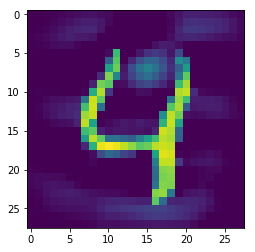

In [74]:
plt.imshow(adversaries[4]['adversary'].reshape(28,28))

In [75]:
adv_df['prediction'].value_counts()/adv_df.shape[0]

8    0.1965
3    0.1770
9    0.1400
5    0.1335
2    0.1170
4    0.0845
7    0.0555
6    0.0495
0    0.0320
1    0.0145
Name: prediction, dtype: float64

In [76]:
adv_df[adv_df['class'] == adv_preds]['prediction'].value_counts()/adv_df[adv_df['class'] == adv_preds]['prediction'].shape[0]

8    0.187139
9    0.142622
5    0.135202
3    0.129431
2    0.103050
4    0.101401
6    0.079143
7    0.065128
0    0.036274
1    0.020610
Name: prediction, dtype: float64

In [77]:
colors = ['black', 'blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'silver', 'cyan']
labels = list(range(10))

In [78]:
# from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
# import PyQt5

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)

# plt.cla()
# pca = PCA(n_components=3)
# pca.fit(X)
# X_pca = pca.transform(X)

# for i in range(len(X_pca)):
#     ax.scatter(X_pca[i,0], X_pca[i,1], X_pca[i,2], color=colors[res_df['prediction'].iloc[i]])

In [79]:
# from sklearn import manifold
# from collections import OrderedDict

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)
# plt.cla()

# # X_dimmed = manifold.TSNE(n_components=3, init='pca', random_state=0).fit_transform(X)
# X_dimmed = manifold.Isomap(10, 3).fit_transform(X)

# for i in range(len(X_dimmed)):
#     ax.scatter(X_dimmed[i,0], X_dimmed[i,1], X_dimmed[i,2], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]])

# handles, labs = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labs, handles))
# ax.legend(by_label.values(), by_label.keys())

In [80]:
from sklearn.decomposition import PCA
from sklearn import manifold
from collections import OrderedDict

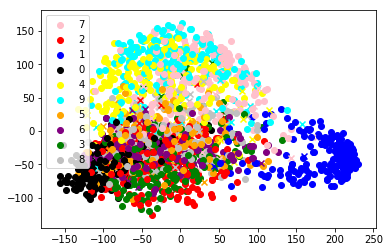

In [81]:
fig, ax = plt.subplots()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

for i in range(len(X_pca)):
    mark = "o" if res_df.iloc[i]['prediction'] == res_df.iloc[i]['class'] else "x"
    ax.scatter(X_pca[i,0], X_pca[i,1], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]], marker=mark)
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())

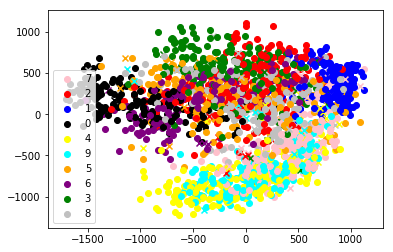

In [82]:
from sklearn import manifold
fig, ax = plt.subplots()
X_dimmed = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(X)
# X_dimmed = manifold.TSNE(n_components=2, init='pca', random_state=5).fit_transform(X)
# X_dimmed = manifold.SpectralEmbedding(n_neighbors=100, n_components=2).fit_transform(X)
# X_dimmed = manifold.MDS(2, max_iter=200, n_init=10).fit_transform(X)
# X_dimmed = manifold.LocallyLinearEmbedding(10, 2, eigen_solver='auto', method='standard').fit_transform(X)


for i in range(len(X_dimmed)):
    mark = "o" if res_df.iloc[i]['prediction'] == res_df.iloc[i]['class'] else "x"
    ax.scatter(X_dimmed[i,0], X_dimmed[i,1], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]], marker=mark)
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())